In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.profile_models as profile_models
import model.profile_performance as profile_performance
import model.train_profile_model as train_profile_model
import feature.util as feature_util
import feature.make_profile_dataset as make_profile_dataset
import plot.viz_sequence as viz_sequence
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

### Define paths for the model and data of interest

In [38]:
# Define the paths to the files and model, and some constants
files_spec_path = "/users/amtseng/att_priors/data/processed/ENCODE_DNase/profile/config/HepG2/HepG2_training_paths.json"

reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1346
profile_length = 1000
num_tasks = 2
use_controls = False
model_class = profile_models.ProfilePredictorWithoutControls
model_path = "/users/amtseng/att_priors/models/trained_models/profile_models/HepG2_prior_freqlimit200_limitsoft0.8/5/model_ckpt_epoch_10.pt"

In [41]:
# Define the paths to the files and model, and some constants
files_spec_path = "/users/amtseng/att_priors/data/processed/ENCODE_DNase/profile/config/K562/K562_training_paths.json"

reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1346
profile_length = 1000
num_tasks = 7
use_controls = False
model_class = profile_models.ProfilePredictorWithoutControls
model_path = "/users/amtseng/att_priors/models/trained_models/profile_models/K562_prior_freqlimit200_limitsoft0.8/1/model_ckpt_epoch_4.pt"

In [3]:
# Extract the file specs
with open(files_spec_path, "r") as f:
    files_spec = json.load(f)
peaks_bed = files_spec["peak_beds"][0]  # First peaks BED, arbitrarily
profile_hdf5 = files_spec["profile_hdf5"]

In [4]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [39]:
model = model_util.restore_model(model_class, model_path)
model.eval()
model = model.to(device) 

### Data preparation
Use classes from `make_profile_dataset` to prepare positive and negative inputs.

In [6]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=input_length)

# Maps coordinates to profiles
coords_to_vals = make_profile_dataset.CoordsToVals(profile_hdf5, profile_length)

# Maps many coordinates to inputs sequences and profiles for the network
def coords_to_network_inputs(coords):
    input_seq = coords_to_seq(coords)
    profs = coords_to_vals(coords)
    return input_seq, np.swapaxes(profs, 1, 2)

In [7]:
# Import set of positive peaks
pos_coords_table = pd.read_csv(peaks_bed, sep="\t", header=None, compression="gzip")

# Negative coordinate sampling
neg_coord_sampler = make_profile_dataset.GenomeIntervalSampler(chrom_sizes, input_length)

### Predicting and plotting profiles

In [8]:
def predict_coords(
    model, coords, fourier_att_prior_freq_limit=160,
    fourier_att_prior_freq_limit_softness=None, print_losses=True
):
    """
    Fetches the necessary data from the given coordinate and runs it through the
    network. Returns the network predictions, the true values from the dataset,
    the input gradients, and the loss values. The returned profiles are in terms
    of raw counts, and the returned counts are also raw. Returned values are all
    NumPy arrays.
    """
    input_seqs, profiles = coords_to_network_inputs(coords)
    
    input_seqs = model_util.place_tensor(torch.tensor(input_seqs)).float()
    profiles = model_util.place_tensor(torch.tensor(profiles)).float()

    if use_controls:
        true_profs = profiles[:, :num_tasks, :, :]
        cont_profs = profiles[:, num_tasks:, :, :]
    else:
        true_profs, cont_profs = profiles, None

    model.zero_grad()
    
    # Run through the model
    input_seqs.requires_grad = True  # Set gradient required
    logit_pred_profs, log_pred_counts = model(input_seqs, cont_profs)
    
    # Compute input gradients
    input_grads, = torch.autograd.grad(
        logit_pred_profs, input_seqs,
        grad_outputs=model_util.place_tensor(torch.ones(logit_pred_profs.size())),
        retain_graph=True, create_graph=True
    )
    input_grads_np = input_grads.detach().cpu().numpy()
    input_seqs_np = input_seqs.detach().cpu().numpy()
    
    input_grads = input_grads * input_seqs
    
    status = model_util.place_tensor(torch.ones(input_seqs.size()[0]))
    loss, (corr_loss, att_loss), (prof_loss, count_loss) = \
        train_profile_model.model_loss(
            model, true_profs, logit_pred_profs, log_pred_counts, 0, 20, 50,
            None, 1, 3, fourier_att_prior_freq_limit,
            fourier_att_prior_freq_limit_softness, False, input_grads, status
    )
    prof_loss, count_loss, att_loss = \
        prof_loss.item(), count_loss.item(), att_loss.item()
    if print_losses:
        print("Profile loss\tCounts loss\tPrior loss")
        print("%6.3f\t%6.3f\t%6.3f" % (prof_loss, count_loss, att_loss))
    
    # Convert logit profile predictions to probabilities
    log_pred_profs = profile_models.profile_logits_to_log_probs(logit_pred_profs, axis=2)
    
    # Add true profiles to get true counts
    true_counts = torch.sum(true_profs, dim=2)
    
    # Truncate input gradients to profile length
    left = int((input_seqs.shape[1] - profile_length) / 2)
    right = left + profile_length
    input_grads = input_grads[:, left:right, :]
    
    return log_pred_profs.detach().cpu().numpy(), log_pred_counts.detach().cpu().numpy(), \
        true_profs.cpu().numpy(), true_counts.cpu().numpy(), input_seqs_np, input_grads_np, \
        prof_loss, count_loss, att_loss

In [9]:
def plot_profiles(pred_profs, true_profs, title=None):
    """
    Plots the given profiles.
    Both arguments should be T x O x 2 NumPy arrays, where the subarrays are the
    tracks for the plus and minus strand, for each task.
    If `normalize` is True, normalize the profiles to be probabilities (i.e.
    each track sums to 1)
    """
    num_tasks, prof_length = pred_profs.shape[0], pred_profs.shape[1]
    fig, ax = plt.subplots(num_tasks, figsize=(15, num_tasks * 4))
    if num_tasks == 1:
        ax = [ax]
    for i in range(num_tasks):
        ax[i].plot(true_profs[i,:,0], color="royalblue", alpha=0.5)
        ax[i].plot(-true_profs[i,:,1], color="goldenrod", alpha=0.5)
        ax[i].plot(pred_profs[i,:,0], color="darkslateblue")
        ax[i].plot(-pred_profs[i,:,1], color="darkorange")
    if title:
        fig.suptitle(title)

### Computing/plotting Fourier transforms

In [10]:
def dft(signal):
    fourier_coeffs = np.fft.fft(signal)
    fourier_freqs = 2 * np.pi * np.fft.fftfreq(signal.size)
    fourier_freqs = fourier_freqs[:int(len(fourier_freqs) / 2)]  # Only the positive frequencies
    mags = np.abs(fourier_coeffs)[:int(len(fourier_coeffs) / 2)]  # Frequency magnitudes are symmetric
    return fourier_freqs, mags

In [11]:
def plot_grad_and_fft(input_grad, input_seq, include_dc=False, pos_limit=None):
    assert len(input_grad.shape) == 2
    assert len(input_seq.shape) == 2
    
    grad_x_seq = np.sum(input_grad * input_seq, axis=1)
    abs_grad = np.abs(grad_x_seq)
    freqs, mags = dft(abs_grad)
    
    if not include_dc:
        freqs, mags = freqs[1:], mags[1:]
    
    # Plot the original signal, absolute value, and the DFT
    fig, ax = plt.subplots(3, 1, figsize=(20, 10))
    ax[0].plot(grad_x_seq)
    ax[0].set_title("Input gradient * input sequence")
    ax[0].margins(0)
    ax[1].plot(abs_grad)
    ax[1].set_title("|Input gradient * input sequence|")
    ax[1].margins(0)
    ax[2].plot(freqs, mags, color="red")
    ax[2].set_xlabel("Frequency (radians)")
    ax[2].set_ylabel("|Frequency component|")
    if pos_limit is not None:
        pos_limit_radians = pos_limit * 2 * np.pi / len(grad_x_seq)
        ax[2].axvline(x=pos_limit_radians, color="black")
    ax[2].margins(0)
    fig.tight_layout()

### View predictions

In [36]:
def predict_and_plot(model, chrom, start, end, seq_slice=slice(650, 750)):
    log_pred_profs, log_pred_counts, true_profs, true_counts, input_seqs, input_grads, \
        prof_loss, count_loss, att_loss = predict_coords(
            model, [(chrom, start, end)] * 50,
            fourier_att_prior_freq_limit=200,
            fourier_att_prior_freq_limit_softness=0.8
    )

    pred_prof_probs = np.exp(log_pred_profs)
    true_prof_probs = true_profs / np.sum(true_profs, axis=2, keepdims=True)
    plot_profiles(pred_prof_probs[0], true_prof_probs[0])

    plot_grad_and_fft(input_grads[0], input_seqs[0], pos_limit=200)
    viz_sequence.plot_weights(input_grads[0][seq_slice])
    viz_sequence.plot_weights((input_grads[0] * input_seqs[0])[seq_slice])

In [24]:
pos_coords_table[pos_coords_table[0].isin(["chr8", "chr10"])].sample(10)

,0,1,2,3,4,5,6,7,8,9
51205,chr8,102810476,102811040,.,984,.,5.03030,18.23069,15.44631,378
17679,chr8,81732238,81732731,.,1000,.,11.24916,35.87917,32.51171,234
60292,chr8,143986055,143986293,.,808,.,5.07364,15.52290,12.83206,161
34394,chr10,112447411,112447664,.,1000,.,8.84620,24.78388,21.78485,67
67594,chr10,128069445,128069658,.,770,.,6.58307,13.46481,10.84664,164
60328,chr10,133309086,133309473,.,1000,.,5.78012,15.51365,12.82308,82
39313,chr8,66428508,66429107,.,1000,.,7.00205,22.50572,19.57896,503
9678,chr10,132654776,132654975,.,1000,.,11.93063,44.64849,40.94603,68
39073,chr10,97445895,97446549,.,1000,.,7.63407,22.61696,19.68660,550
78593,chr10,97914833,97915202,.,1000,.,5.19523,10.11360,7.63361,308


Profile loss	Counts loss	Prior loss
566.566	 0.043	 0.132


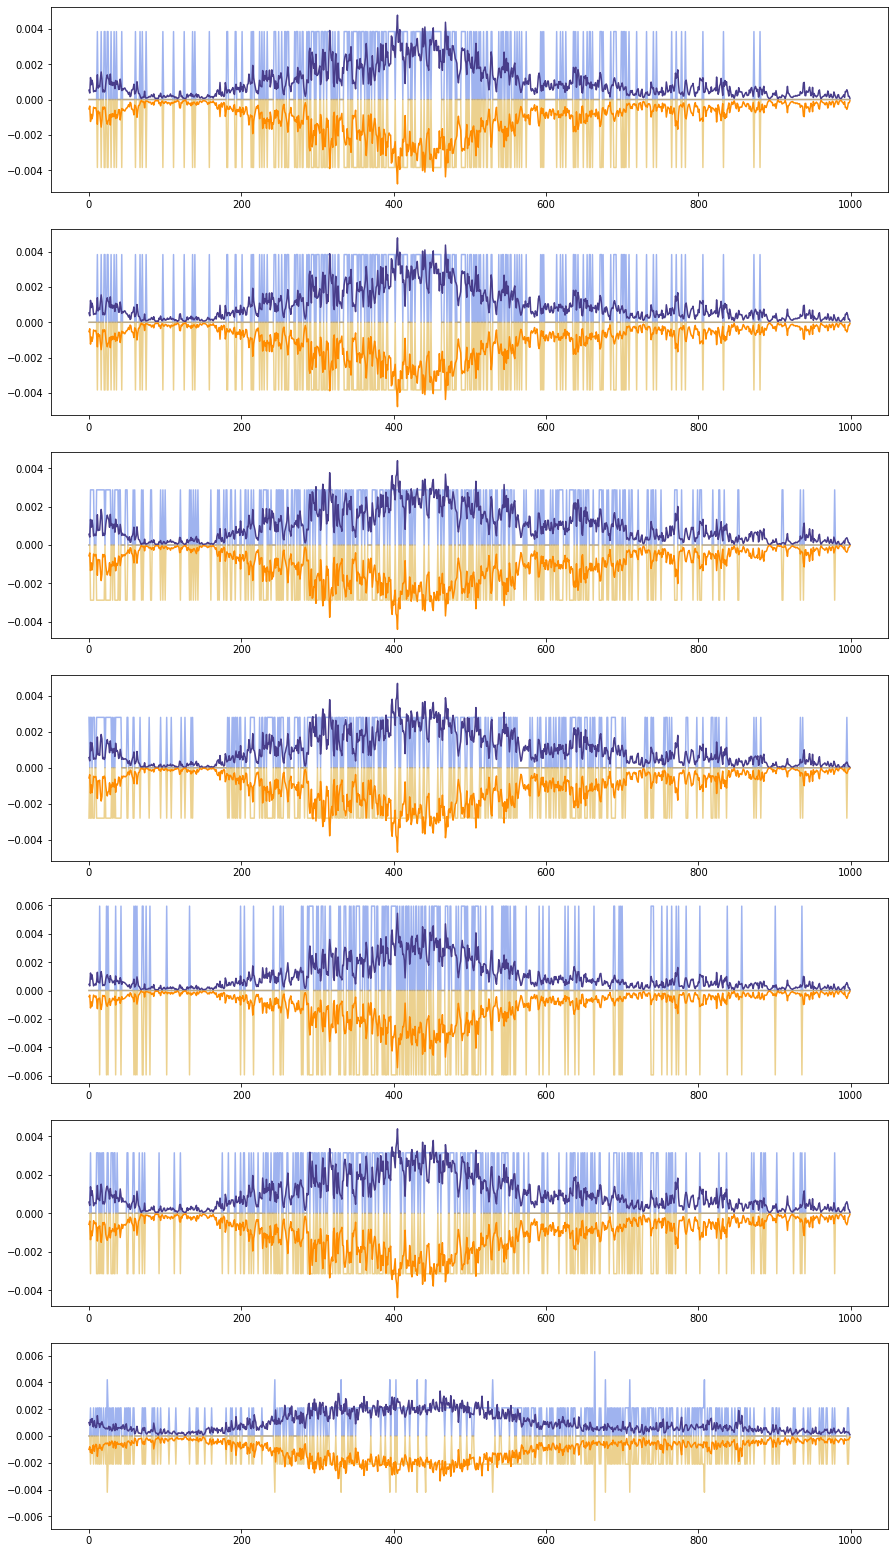

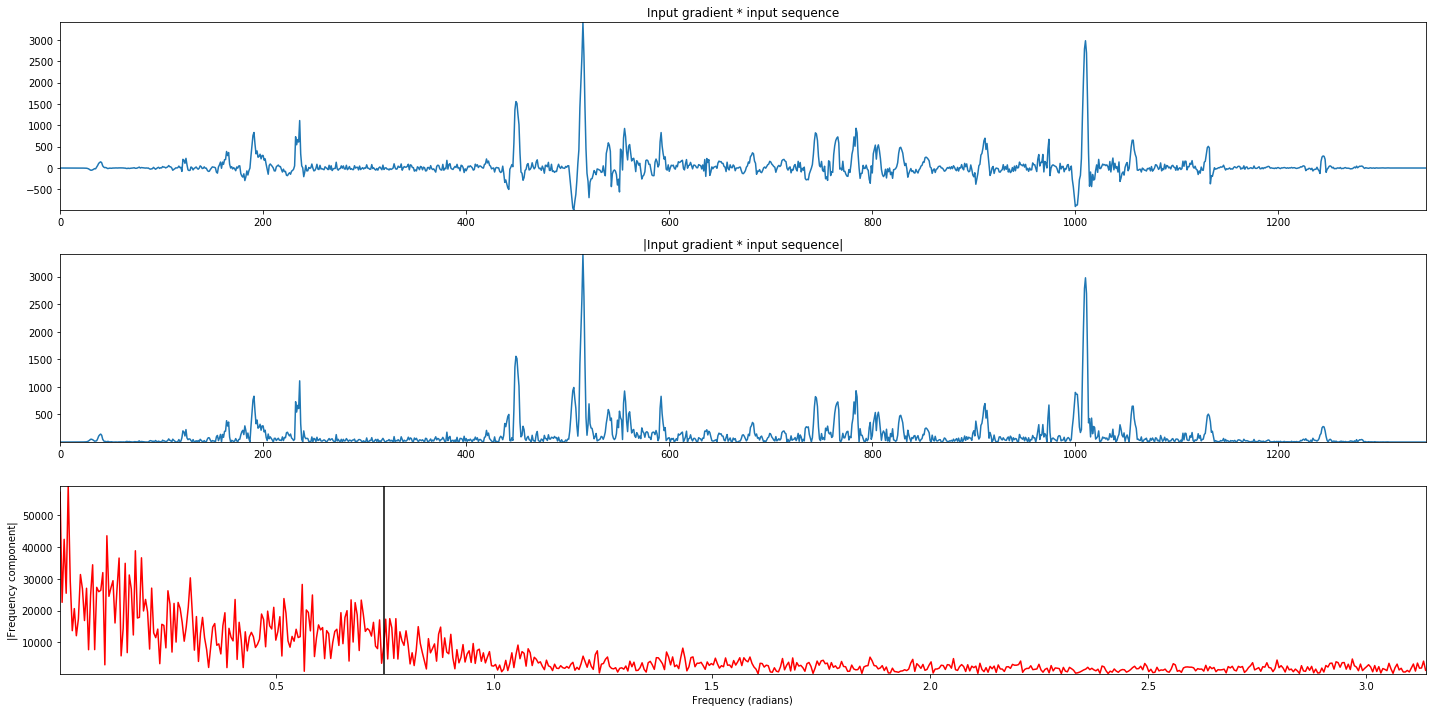

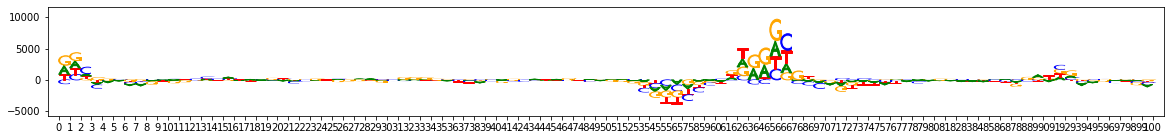

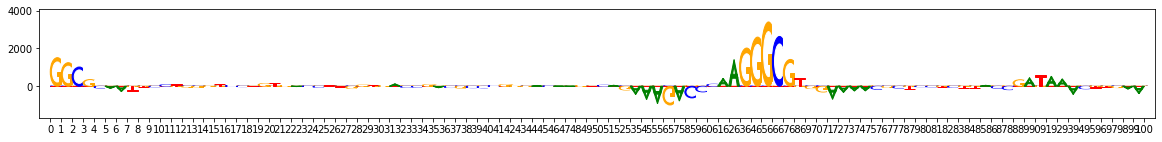

In [45]:
# K562
predict_and_plot(model, "chr8", 124538852, 124539468, slice(450, 550))

Profile loss	Counts loss	Prior loss
171.913	 0.392	 0.090


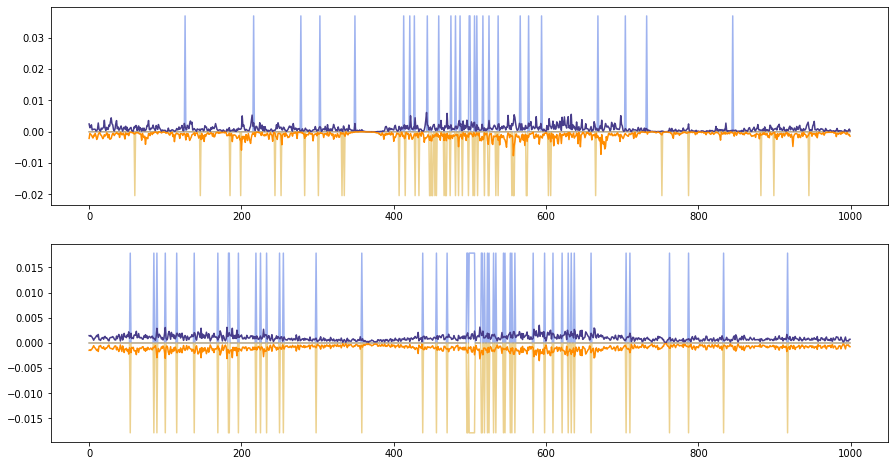

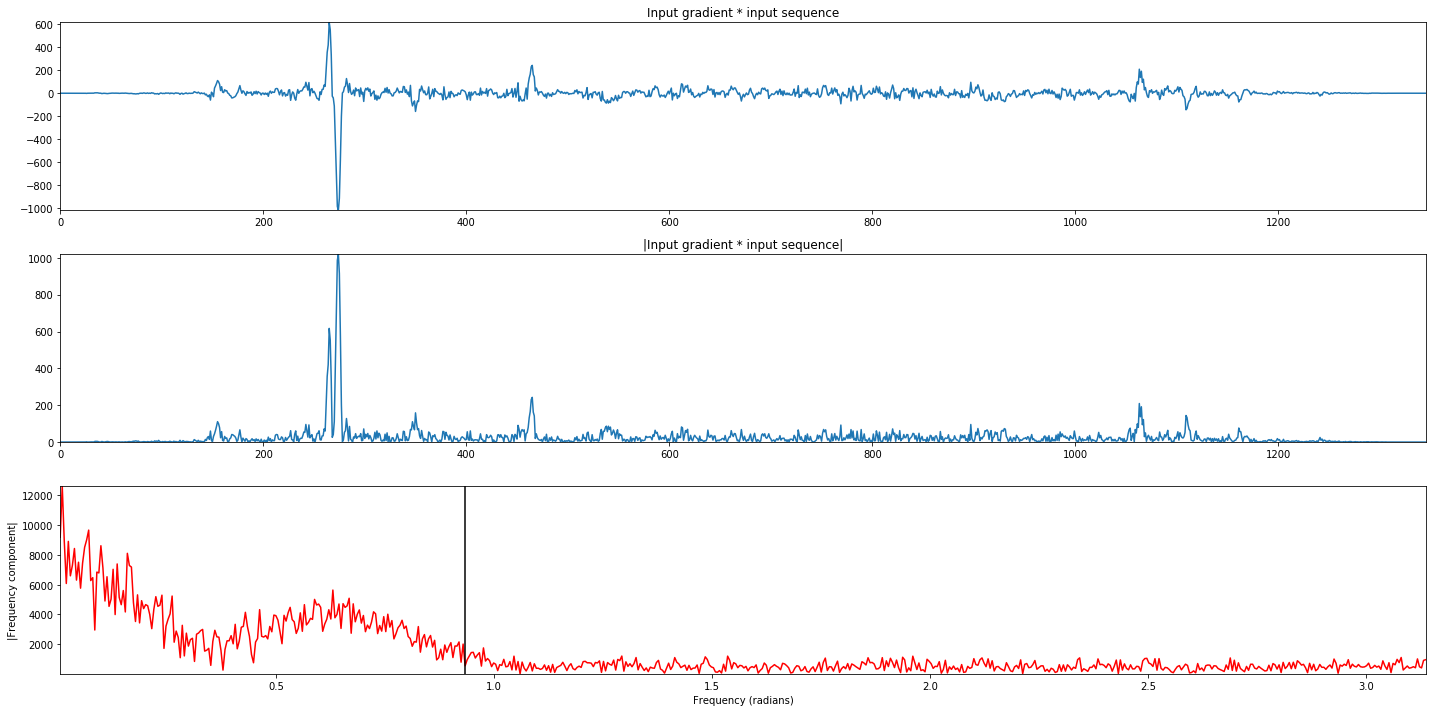

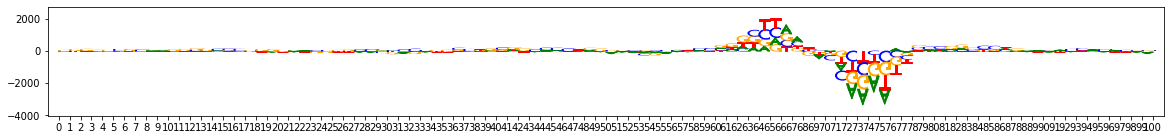

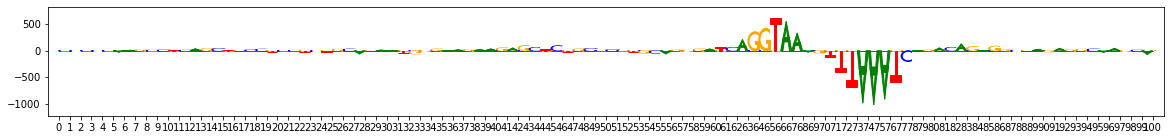

In [20]:
predict_and_plot(model, "chr8", 139656283, 139656491, slice(200, 300))

Profile loss	Counts loss	Prior loss
190.872	 0.139	 0.214


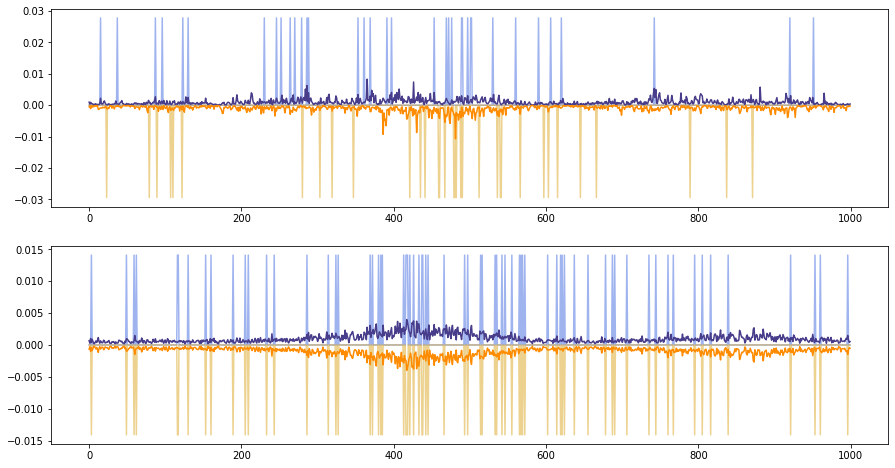

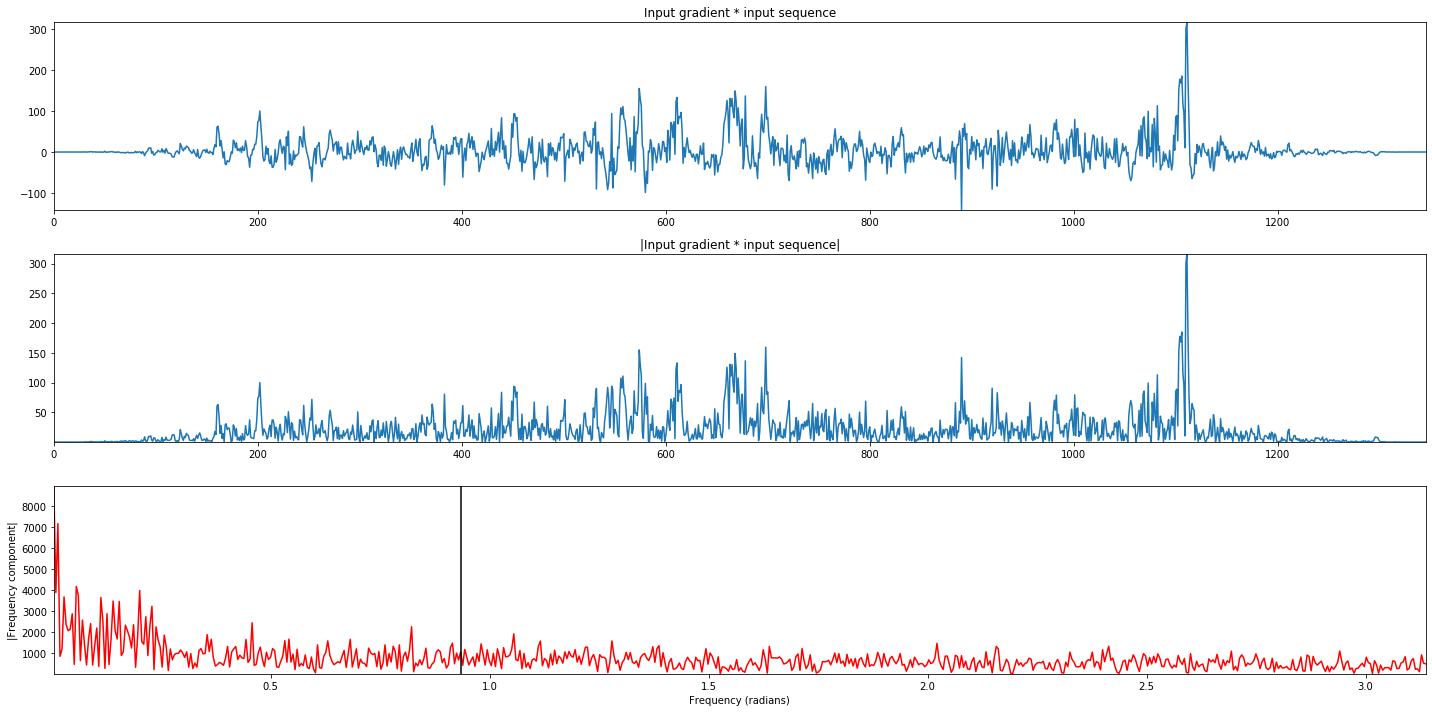

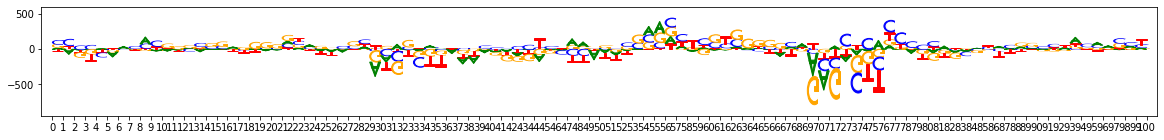

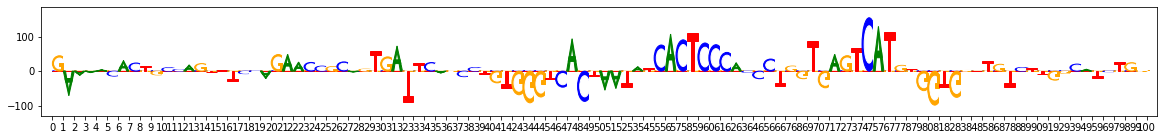

In [21]:
predict_and_plot(model, "chr10", 97882580, 97882857, slice(500, 600))

Profile loss	Counts loss	Prior loss
179.191	 0.344	 0.056


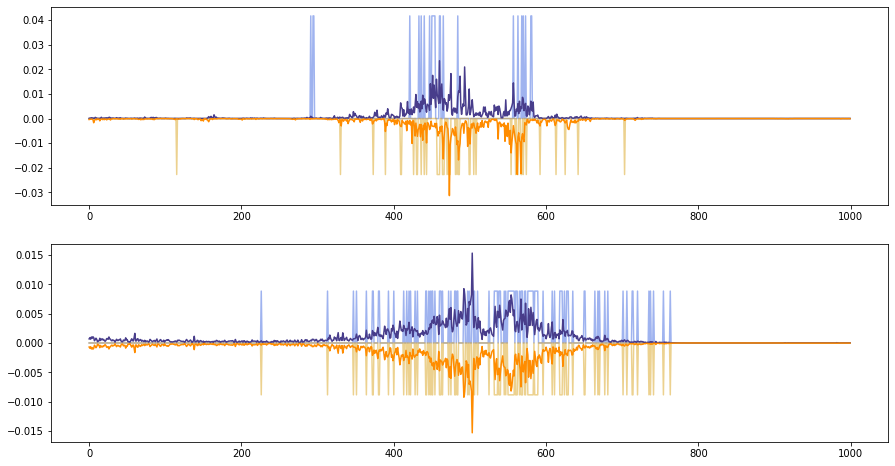

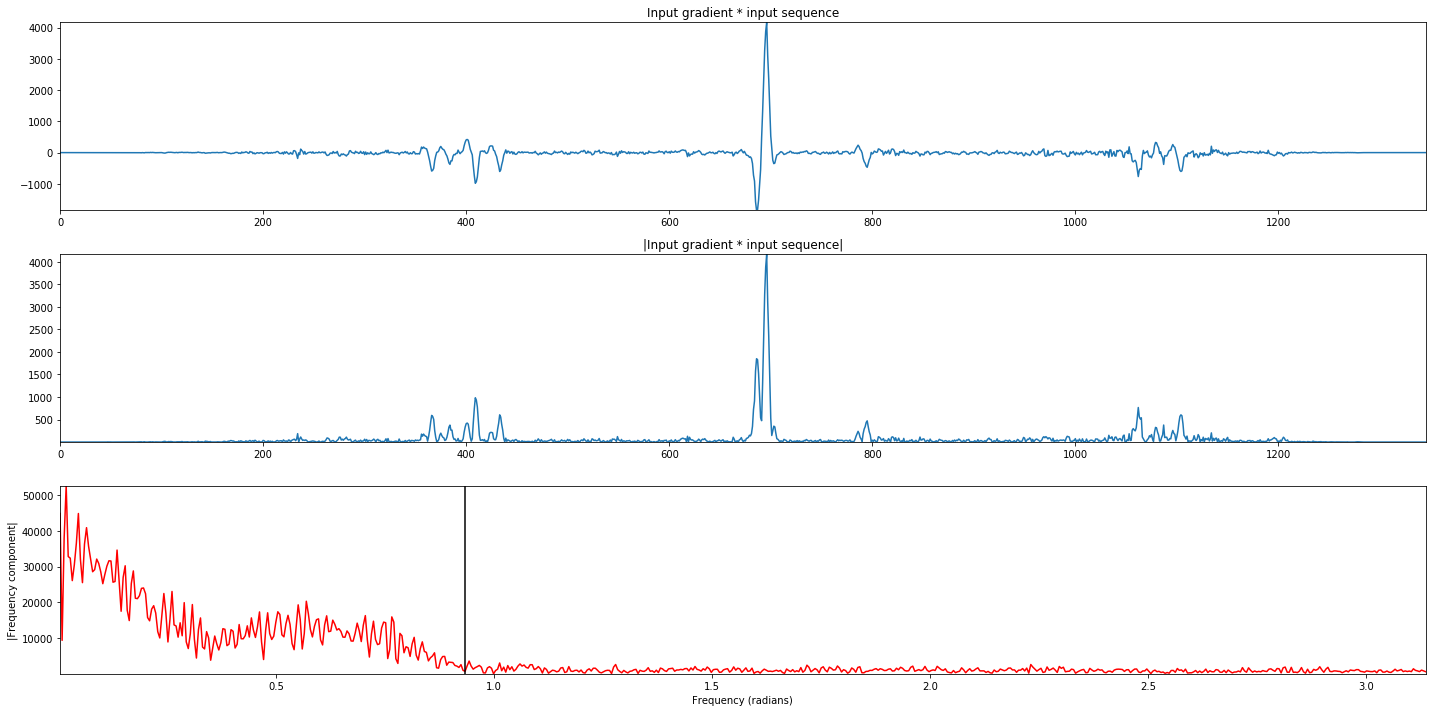

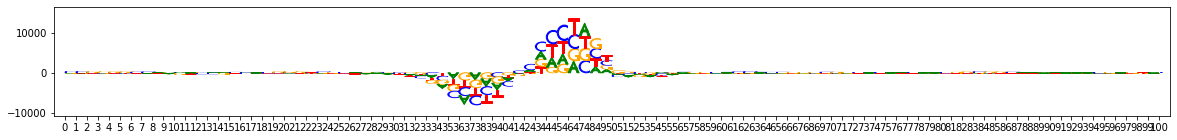

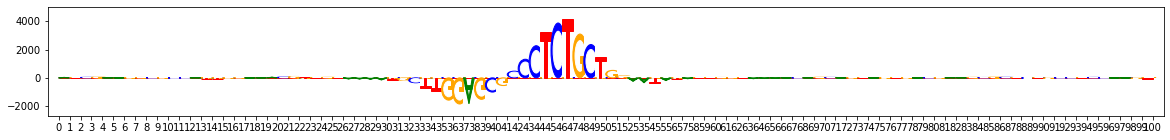

In [22]:
predict_and_plot(model, "chr4", 87235819, 87236074)

Profile loss	Counts loss	Prior loss
409.325	 0.305	 0.047


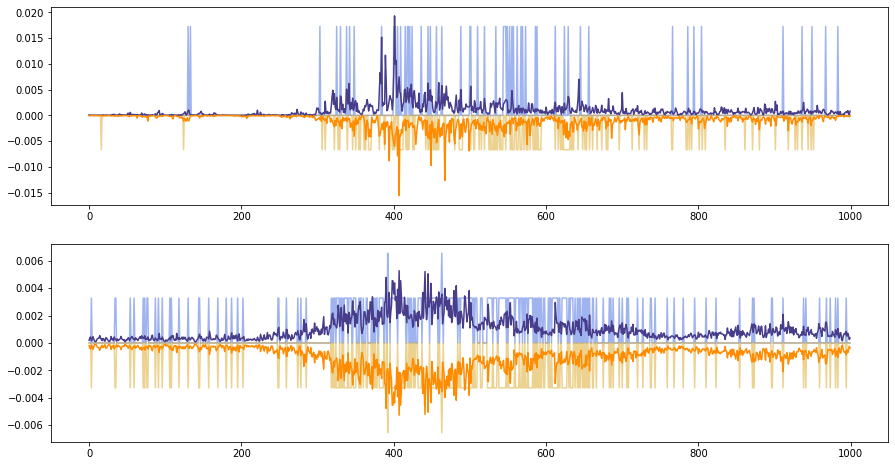

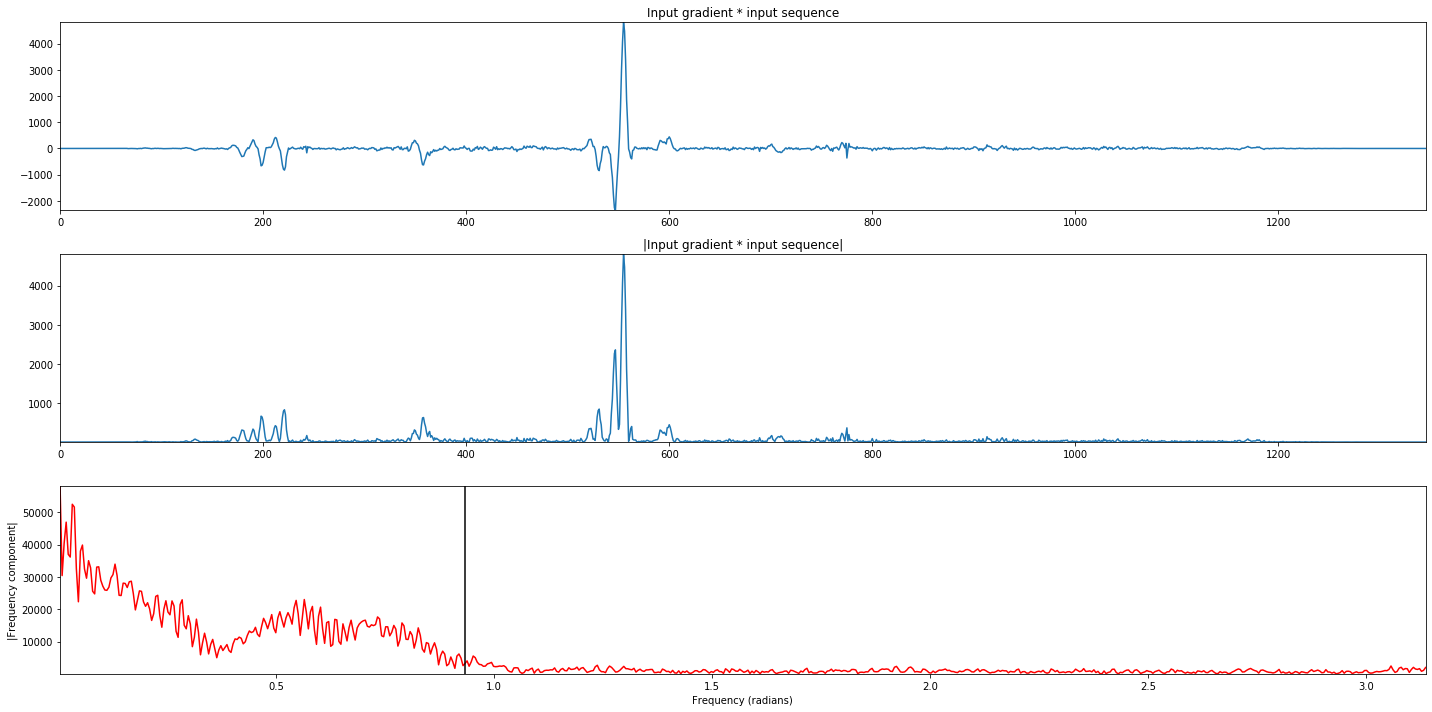

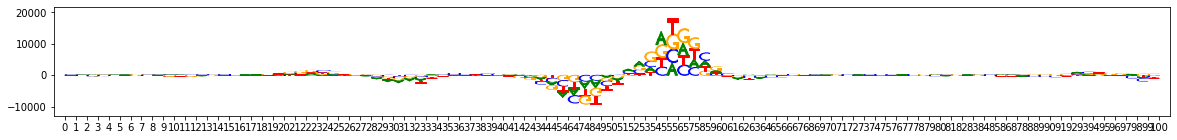

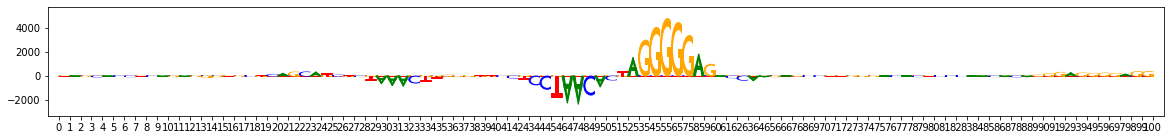

In [23]:
predict_and_plot(model, "chr10", 102503722, 102504108, slice(500, 600))

Profile loss	Counts loss	Prior loss
211.737	 1.643	 0.090


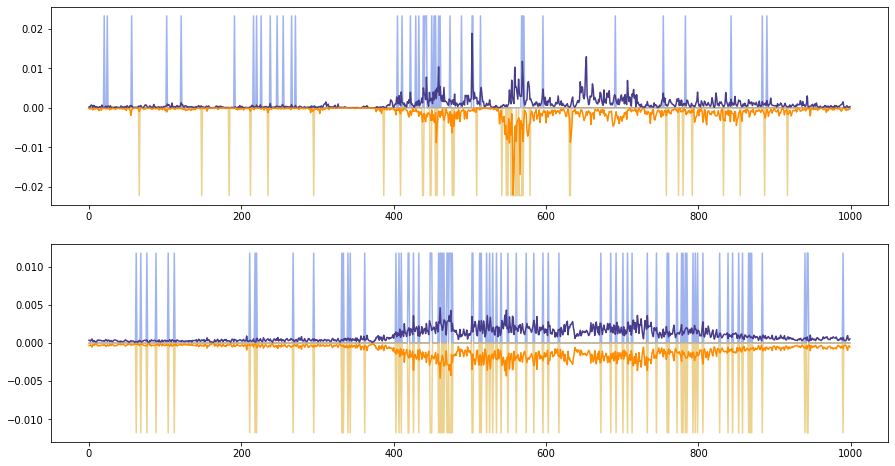

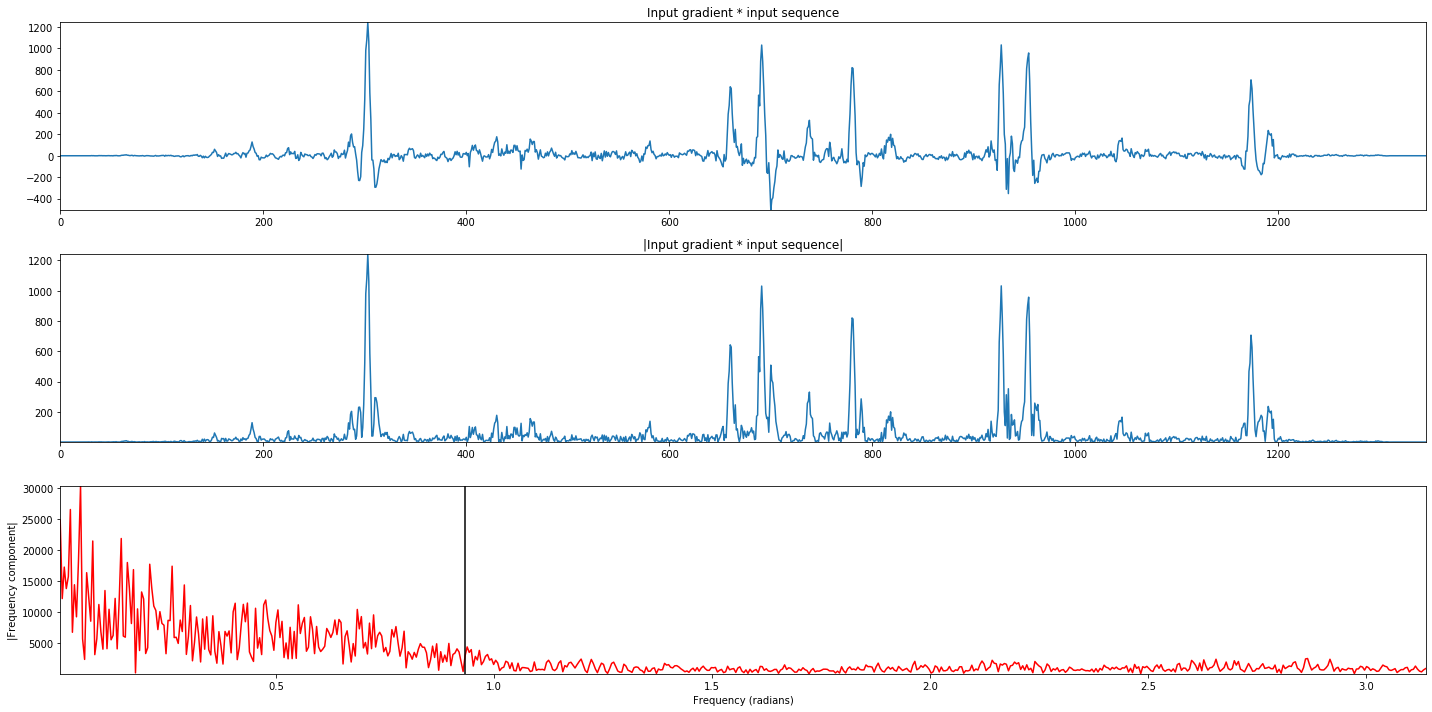

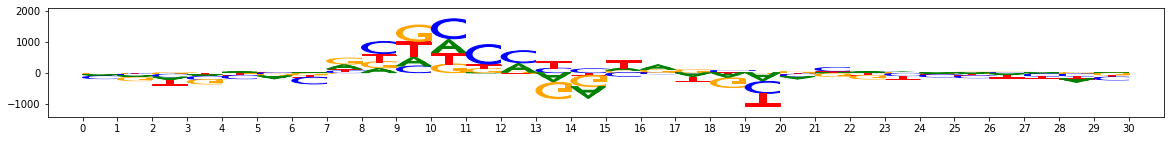

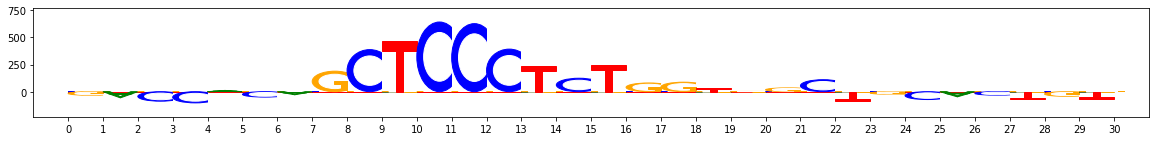

In [40]:
predict_and_plot(model, "chr10", 128069445, 128069658, slice(650, 680))